In [1]:
from __future__ import print_function

import plotly.express as px

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd
import geopandas as gpd

import datetime
import pickle

import matplotlib.pyplot as plt
import ndpretty

In [2]:
ndpretty.default_max_dim_size = 50
ndpretty.default()

In [3]:
# %matplotlib widget

## Load data

### Metadata

In [4]:
bj = pd.read_csv('data/bj_stations.csv')
bj = bj.rename(columns={'deviceid': 'device_id'})
bj["city"] = "Beijing"

hebei = pd.read_csv('data/hebei_translated.csv')

meta = pd.concat([bj, hebei])

meta = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(meta.lon, meta.lat))

In [5]:
meta_plot = meta.copy()
meta_plot['color'] = 1
meta_plot.loc[meta_plot['city'] == 'Beijing', 'color'] = 0

fig = px.scatter_mapbox(meta_plot,
                        lat=meta_plot.geometry.y,
                        lon=meta_plot.geometry.x,
                        color='color',
                        color_continuous_scale=px.colors.sequential.Blackbody,
                        hover_name='city',
                        hover_data=["device_id", 'device_name'],
                        width=1000, height=700)

fig.update_layout(
    title='Devices',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        bearing=0,
        center=dict(
            lat=39,
            lon=117
        ),
        pitch=0,
        zoom=5,
        style='stamen-terrain'
    ),
)

fig.show()

### Air quality measurements and weather data

First we set a start and an end date for the data considered in this project.

In [6]:
start = pd.Timestamp('2016-01-01 00:00:00')
end = pd.Timestamp('2021-01-01 00:00:00')

date_idx = pd.date_range(start, end, freq='h')

In [7]:
measurements = []
no_weather_devices = []

for device_id in meta['device_id'].unique():
    #device_id = '1029A'

    air_df = pd.read_csv('data/air/' + device_id + '.csv')
    air_df['time'] = pd.to_datetime(air_df["time"])
    air_df = air_df.set_index('time', drop=False).reindex(index=date_idx)
    air_df['time'] = air_df.index
    air_df['device_id'] = device_id
    air_df['city'] = meta[meta['device_id'] == device_id]['city'].iloc[0]

    try:
        weather_df = pd.read_csv('data/wea/' + device_id + '.csv')
        weather_df['time'] = pd.to_datetime(weather_df["datetime"])
        del weather_df['datetime']

        both_df = air_df.merge(weather_df, on='time', how='left')

        measurements.append(both_df)
    except Exception as e:
        print(e)
        measurements.append(air_df)
        no_weather_devices.append(device_id)

all_df = pd.concat(measurements)

assert not all_df['time'].isnull().any(), "Time values mustn't be NaN"

print(f"Loaded air quality data from {len(measurements)} devices")

[Errno 2] No such file or directory: 'data/wea/fangshan.csv'
[Errno 2] No such file or directory: 'data/wea/miyun.csv'
[Errno 2] No such file or directory: 'data/wea/yanqing.csv'
[Errno 2] No such file or directory: 'data/wea/badaling.csv'
[Errno 2] No such file or directory: 'data/wea/miyunshuiku.csv'
[Errno 2] No such file or directory: 'data/wea/yufa.csv'
[Errno 2] No such file or directory: 'data/wea/liulihe.csv'
[Errno 2] No such file or directory: 'data/wea/1042A.csv'
[Errno 2] No such file or directory: 'data/wea/1043A.csv'
[Errno 2] No such file or directory: 'data/wea/1044A.csv'
[Errno 2] No such file or directory: 'data/wea/1045A.csv'
[Errno 2] No such file or directory: 'data/wea/1046A.csv'
[Errno 2] No such file or directory: 'data/wea/1047A.csv'
[Errno 2] No such file or directory: 'data/wea/1048A.csv'
[Errno 2] No such file or directory: 'data/wea/1049A.csv'
[Errno 2] No such file or directory: 'data/wea/1050A.csv'
[Errno 2] No such file or directory: 'data/wea/1067A.csv'

Look only at data from 2020 onwards

In [8]:
# all_df = all_df[all_df['time'] >= '2020-01-01']

In [9]:
class Event:
    def __init__(self, name, start, end, color):
        self.name = name
        self.start = start
        self.end = end
        self.color = color
    
    def __repr__(self):
        date_fmt = '%Y/%m/%d'
        return f" Event '{self.name}' ({self.start.strftime(date_fmt)} - {self.end.strftime(date_fmt)})"

    def __str__(self):
        return self.name

lockdowns = []

lockdowns.append(Event("LD 1", pd.to_datetime('2020-01-23'), pd.to_datetime('2020-04-08'), 'green'))
lockdowns.append(Event("LD 2 (light)", pd.to_datetime('2020-06-15'), pd.to_datetime('2020-09-01'), 'blue'))

lockdowns

[ Event 'LD 1' (2020/01/23 - 2020/04/08),
  Event 'LD 2 (light)' (2020/06/15 - 2020/09/01)]

In [10]:
feature_list = list(all_df.columns.drop(['time', 'device_id']))

In [169]:
days_list = pd.date_range(all_df["time"].min(), all_df["time"].max(), freq='D')
days_list_formatted = [(date.strftime(' %d-%m-%y '), date) for date in days_list]

ld1 = lockdowns[0]
start = ld1.start - datetime.timedelta(days=14)
end = ld1.end + datetime.timedelta(days=14)

date_slider = widgets.SelectionRangeSlider(
    options=days_list_formatted,
    index=(0, len(days_list_formatted) - 1),
    value=(start, end),
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

In [170]:
devices = meta['device_id']
descriptions = meta['device_id'] + " (" + meta['city'] + ")"
dic = dict(zip(descriptions, devices))

In [176]:
def plot_data(data, devices, date_range, feature, events=[], device_id_mapping=None):
    plt.figure(figsize=(10,5))

    # plot events
    for event in events:
        plt.axvspan(event.start, event.end, color=event.color, alpha=0.1, label=event.name)

    # plot measurements
    (start, end) = date_range
    for device in devices:
        if device_id_mapping is not None:
            device_id = device_id_mapping[device]
        else:
            device_id = device
        y = data[(data['device_id'] == device_id) & (data['time'] >= start) & (data['time'] < end)]
        plt.plot(y['time'], y[feature], label=device)

    plt.tight_layout()

    plt.title(feature)
    plt.legend(loc='upper left')
    axes = plt.gca()
    axes.set_xlim([start,end])

    plt.show()

device_widget = widgets.SelectMultiple(
    options=dic.keys(),
    rows=15,
    description='Devices',
    disabled=False
)

feature_widget = widgets.Dropdown(
    options=feature_list,
    value='pm25',
    description='Feature:'
)

interact_manual(plot_data, data=fixed(all_df), devices=device_widget, date_range=date_slider, feature=feature_widget, events=fixed(lockdowns), device_id_mapping=fixed(dic))

interactive(children=(SelectMultiple(description='Devices', options=('dongsi (Beijing)', 'tiantan (Beijing)', …

<function __main__.plot_data(data, devices, date_range, feature, events=[], device_id_mapping=None)>

In [14]:
city_means = all_df.groupby(by=['city', 'time']).mean().reset_index()
city_means = city_means.rename(columns={'city': 'device_id'})

In [138]:
city_means

,device_id,time,co,no2,o3,pm10,pm25,so2,temperature,humidity,windSpeed,windBearing,precipIntensity
0,Baoding,2016-01-01 00:00:00,6.110833,152.000000,7.500000,NaN,NaN,158.333333,NaN,NaN,NaN,NaN,NaN
1,Baoding,2016-01-01 01:00:00,6.463000,153.000000,8.666667,375.666667,301.000000,146.333333,NaN,NaN,NaN,NaN,NaN
2,Baoding,2016-01-01 02:00:00,7.179500,148.000000,9.000000,402.166667,320.833333,135.666667,-4.115741,0.875,2.240,71.0,0.0
3,Baoding,2016-01-01 03:00:00,6.713000,132.833333,8.166667,379.666667,302.666667,127.333333,NaN,NaN,NaN,NaN,NaN
4,Baoding,2016-01-01 04:00:00,4.945667,108.333333,7.333333,263.666667,211.333333,116.500000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
526183,Zhangjiakou,2020-12-31 20:00:00,0.925000,34.250000,34.750000,57.000000,28.500000,25.750000,-13.032222,0.260,6.018,323.8,0.0
526184,Zhangjiakou,2020-12-31 21:00:00,0.825000,26.000000,39.750000,53.333333,27.000000,18.750000,-13.811111,0.274,6.064,315.2,0.0
526185,Zhangjiakou,2020-12-31 22:00:00,0.900000,25.000000,37.500000,69.250000,43.250000,22.000000,-14.842222,0.300,5.670,323.6,0.0
526186,Zhangjiakou,2020-12-31 23:00:00,1.000000,30.750000,27.750000,57.250000,32.250000,27.250000,-15.684444,0.312,4.870,332.0,0.0


In [175]:
city_widget = widgets.SelectMultiple(
    options=list(city_means['device_id'].unique()),
    rows=15,
    description='Devices',
    disabled=False
)

interact_manual(plot_data, data=fixed(city_means), devices=city_widget, date_range=date_slider, feature=feature_widget, events=fixed(lockdowns), device_id_mapping=fixed(None))

interactive(children=(SelectMultiple(description='Devices', options=('Baoding', 'Beijing', 'Cangzhou', 'Chengd…

<function __main__.plot_data(data, devices, date_range, feature, events=[], device_id_mapping=None)>

In [164]:
def show_map(time, feature):
    x = all_df[all_df['time'] == time]
    
    x = x.merge(meta, on=['device_id', 'city'])
    x = gpd.GeoDataFrame(x)

    x["size"] = 10

    fig = px.scatter_mapbox(x,
                            lat=x.geometry.y,
                            lon=x.geometry.x,
                            hover_name='city',
                            hover_data=["device_id", 'device_name'],
                            color=feature,
                            size='size',
                            color_continuous_scale=px.colors.sequential.matter,
                            width=1000, height=700)

    fig.update_layout(
        title=f'Measurements on {time}',
        autosize=True,
        hovermode='closest',
        showlegend=False,
        mapbox=dict(
            bearing=0,
            center=dict(
                lat=39,
                lon=117
            ),
            pitch=0,
            zoom=5,
            style='stamen-terrain' # 'stamen-terrain'
        ),
    )

    fig.show()
    # plt.show()s

# interact(show_map, time=date_slider)
show_map('2020-04-15 00:00:00', 'pm25')

## Lockdown analysis

In [18]:
ld1 = lockdowns[0]
start = ld1.start - datetime.timedelta(days=14)
end = ld1.end + datetime.timedelta(days=14)

In [19]:
interact_manual(plot_data, data=fixed(all_df), devices=device_widget, date_range=fixed((start, end)), feature=feature_list, events=fixed(lockdowns), device_id_mapping=fixed(dic))

interactive(children=(SelectMultiple(description='Devices', options=('dongsi (Beijing)', 'tiantan (Beijing)', …

<function __main__.plot_data(data, devices, date_range, feature, events=[], device_id_mapping=None)>

In [20]:
all_df

,co,no2,o3,pm10,pm25,so2,time,device_id,city,temperature,humidity,windSpeed,windBearing,precipIntensity
0,3.4,98.0,2.0,209.0,200.0,31.0,2016-01-01 00:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
1,3.4,97.0,3.0,203.0,193.0,46.0,2016-01-01 01:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
2,3.7,102.0,3.0,237.0,219.0,49.0,2016-01-01 02:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
3,3.1,94.0,3.0,196.0,187.0,40.0,2016-01-01 03:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
4,3.1,91.0,2.0,NaN,160.0,35.0,2016-01-01 04:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43844,0.8,42.0,29.0,61.0,30.0,8.0,2020-12-31 20:00:00,1080A,Xingtai,-3.877778,0.16,4.47,227.0,0.0
43845,0.7,50.0,21.0,62.0,28.0,8.0,2020-12-31 21:00:00,1080A,Xingtai,-4.450000,0.15,3.53,167.0,0.0
43846,0.7,57.0,13.0,58.0,27.0,9.0,2020-12-31 22:00:00,1080A,Xingtai,-5.950000,0.18,3.24,355.0,0.0
43847,0.8,62.0,8.0,60.0,27.0,10.0,2020-12-31 23:00:00,1080A,Xingtai,-7.233333,0.19,3.36,285.0,0.0


## PM2.5 GNN

In [21]:
data_path = "Previous work/PM2.5-GNN/data/"

know_air = np.load(data_path + "KnowAir.npy")
cities = pd.read_table(data_path + "city.txt", delimiter=' ', header=None)
altitude = np.load(data_path + "altitude.npy")

In [22]:
cities

,0,1,2,3
0,0,Beijing,116.398250,40.045975
1,1,Tianjin,117.322167,39.077683
2,2,Shijiazhuang,114.493171,38.033629
3,3,Tangshan,118.182917,39.644953
4,4,Qinhuangdao,119.606875,39.936250
...,...,...,...,...
179,179,Dingxi,104.619850,35.584450
180,180,Linxiazhou,103.210150,35.601800
181,181,Wuzhong,106.199250,37.978350
182,182,Zhongwei,105.188550,37.258700


In [23]:
all_df

,co,no2,o3,pm10,pm25,so2,time,device_id,city,temperature,humidity,windSpeed,windBearing,precipIntensity
0,3.4,98.0,2.0,209.0,200.0,31.0,2016-01-01 00:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
1,3.4,97.0,3.0,203.0,193.0,46.0,2016-01-01 01:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
2,3.7,102.0,3.0,237.0,219.0,49.0,2016-01-01 02:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
3,3.1,94.0,3.0,196.0,187.0,40.0,2016-01-01 03:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
4,3.1,91.0,2.0,NaN,160.0,35.0,2016-01-01 04:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43844,0.8,42.0,29.0,61.0,30.0,8.0,2020-12-31 20:00:00,1080A,Xingtai,-3.877778,0.16,4.47,227.0,0.0
43845,0.7,50.0,21.0,62.0,28.0,8.0,2020-12-31 21:00:00,1080A,Xingtai,-4.450000,0.15,3.53,167.0,0.0
43846,0.7,57.0,13.0,58.0,27.0,9.0,2020-12-31 22:00:00,1080A,Xingtai,-5.950000,0.18,3.24,355.0,0.0
43847,0.8,62.0,8.0,60.0,27.0,10.0,2020-12-31 23:00:00,1080A,Xingtai,-7.233333,0.19,3.36,285.0,0.0


In [89]:
# time × city × measure (17 features, 1 col for PM25)
np.isnan(know_air).any()

False

In [25]:
# altitude

In [97]:
with open(data_path + "city_dict.pkl", 'rb') as f:
    city_dict = pickle.load(f)
city_dict['Beijing']

[['1001A', 116.366, 39.8673, 'Wanshouxigong'],
 ['1002A', 116.17, 40.2865, 'Dingling'],
 ['1003A', 116.434, 39.9522, 'Dongsi'],
 ['1004A', 116.434, 39.8745, 'Tiantan'],
 ['1005A', 116.473, 39.9716, 'Nongzhanguan'],
 ['1006A', 116.361, 39.9425, 'Guanyuan'],
 ['1007A', 116.315, 39.9934, 'Haidianquwanliu'],
 ['1008A', 116.72, 40.1438, 'Shunyixincheng'],
 ['1009A', 116.64399999999999, 40.3937, 'Huairouzhen'],
 ['1010A', 116.23, 40.1952, 'Changpingzhen'],
 ['1011A', 116.40700000000001, 40.0031, 'Aotizhongxin'],
 ['1012A', 116.225, 39.9279, 'Gucheng']]

In [133]:
all_x = list(map(lambda x: x[1], city_dict['Beijing']))
all_y = list(map(lambda x: x[2], city_dict['Beijing']))

all_bj = gpd.GeoDataFrame(geometry=gpd.points_from_xy(all_x, all_y))
all_bj['color'] = 1

In [131]:
city_x, city_y = cities.loc[0][2], cities.loc[0][3]
all_bj = all_bj.append({'color': 0.5, 'geometry': gpd.points_from_xy([city_x], [city_y])[0]}, ignore_index=True)

In [132]:

# meta_plot.loc[meta_plot['city'] == 'Beijing', 'color'] = 0

fig = px.scatter_mapbox(all_bj,
                        lat=all_bj.geometry.y,
                        lon=all_bj.geometry.x,
                        color='color',
                        color_continuous_scale=px.colors.sequential.Blackbody,
                        #hover_name='city',
                        #hover_data=["device_id", 'device_name'],
                        width=1000, height=700)

fig.update_layout(
    title='Devices',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        bearing=0,
        center=dict(
            lat=40,
            lon=116
        ),
        pitch=0,
        zoom=8,
        style='stamen-terrain'
    ),
)

fig.show()

In [99]:
know_air

11688×184×18 float64 ndarray


interactive(children=(Text(value='[:100, :100, 0]', description='Slice:', placeholder='e.g. [:100, :100, 0]'),…

### Check for missing data

In [27]:
num_devices = len(all_df['device_id'].unique())

In [28]:
all_df.shape[0], all_df.shape[0] / num_devices

(3814863, 43849.0)

In [145]:
t = city_means['time']

In [153]:
# select only every third hour (that's how they use it in PM2.5-GNN) - use %2==2, since we have most data for (2:00, 5:00, 8:00, etc.)
filtered_city_means = city_means[city_means['time'].dt.hour % 6 == 2]
del filtered_city_means['co']
del filtered_city_means['no2']
del filtered_city_means['o3']
del filtered_city_means['pm10']
del filtered_city_means['so2']
# filtered_city_means
missing_city_means = filtered_city_means[filtered_city_means.isnull().any(axis=1)]

In [163]:
all_df[(all_df['city'] == 'Beijing') & (all_df['time'] == '2016-03-08 02:00:00')]

,co,no2,o3,pm10,pm25,so2,time,device_id,city,temperature,humidity,windSpeed,windBearing,precipIntensity
1610,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-08 02:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
1610,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-08 02:00:00,tiantan,Beijing,0.272222,0.22,7.44,42.0,0.0
1610,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-08 02:00:00,guanyuan,Beijing,0.233333,0.22,7.28,41.0,0.0
1610,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-08 02:00:00,wanshouxigong,Beijing,0.244444,0.22,7.33,42.0,0.0
1610,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-08 02:00:00,aotizhongxin,Beijing,0.266667,0.22,7.36,42.0,0.0
1610,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-08 02:00:00,nongzhanguan,Beijing,0.288889,0.22,7.51,42.0,0.0
1610,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-08 02:00:00,wanliu,Beijing,0.283333,0.22,7.14,41.0,0.0
1610,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-08 02:00:00,beibuxinqu,Beijing,0.338889,0.22,6.87,40.0,0.0
1610,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-08 02:00:00,zhiwuyuan,Beijing,-0.472222,0.23,6.98,41.0,0.0
1610,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-08 02:00:00,fengtaihuayuan,Beijing,0.266667,0.22,7.20,41.0,0.0


In [157]:
missing_city_means[missing_city_means['device_id'] == 'Beijing']

,device_id,time,pm25,temperature,humidity,windSpeed,windBearing,precipIntensity
45459,Beijing,2016-03-08 02:00:00,NaN,0.187037,0.220370,7.625556,42.259259,0.000000
46449,Beijing,2016-04-18 08:00:00,NaN,13.851235,0.311852,6.720000,0.000000,0.000000
46473,Beijing,2016-04-19 08:00:00,NaN,10.847942,0.627037,6.720000,120.000000,0.000000
48915,Beijing,2016-07-30 02:00:00,NaN,27.862346,0.844074,6.720000,110.000000,0.000000
49149,Beijing,2016-08-08 20:00:00,NaN,26.843621,0.662222,4.480000,161.000000,0.000000
...,...,...,...,...,...,...,...,...
86283,Beijing,2020-11-03 02:00:00,NaN,3.484362,0.182963,3.548148,276.851852,0.000000
86289,Beijing,2020-11-03 08:00:00,NaN,2.942798,0.256296,3.371111,288.370370,0.000000
86841,Beijing,2020-11-26 08:00:00,NaN,-1.250206,0.608889,2.531481,75.296296,0.000000
87237,Beijing,2020-12-12 20:00:00,NaN,-0.088477,0.678519,6.358148,261.074074,0.007615


### Generate my own input data

In [31]:
meta

,device_id,lon,lat,city,device_name,geometry
0,dongsi,116.4170,39.9290,Beijing,NaN,POINT (116.41700 39.92900)
1,tiantan,116.4070,39.8860,Beijing,NaN,POINT (116.40700 39.88600)
2,guanyuan,116.3390,39.9290,Beijing,NaN,POINT (116.33900 39.92900)
3,wanshouxigong,116.3520,39.8780,Beijing,NaN,POINT (116.35200 39.87800)
4,aotizhongxin,116.3970,39.9820,Beijing,NaN,POINT (116.39700 39.98200)
...,...,...,...,...,...,...
47,1076A,115.6906,37.7390,Hengshui,Municipal Environmental Protection Bureau,POINT (115.69060 37.73900)
48,1077A,114.4821,37.0967,Xingtai,Dahuo Spring,POINT (114.48210 37.09670)
49,1078A,114.5261,37.0533,Xingtai,Xing Teachers College,POINT (114.52610 37.05330)
50,1079A,114.5331,37.0964,Xingtai,Road and Bridge Company,POINT (114.53310 37.09640)


In [32]:
cities_export = meta[['device_id', 'lon', 'lat']]

In [33]:
with open(data_path + 'city_import.txt', 'w') as city_f:
    city_f.write(cities_export.to_csv(sep=' ', header=False))

### KnowAir.npy

In [34]:
know_air.shape[0]

11688

In [35]:
data_start = pd.to_datetime("2015-01-01 00:00")
data_end = pd.to_datetime("2018-12-31 21:00")

pd.Timedelta(data_end - data_start), (1460 * 24 + 21 + 3), (1460 * 24 + 21 + 3) / 3

(Timedelta('1460 days 21:00:00'), 35064, 11688.0)

In [36]:
all_df

,co,no2,o3,pm10,pm25,so2,time,device_id,city,temperature,humidity,windSpeed,windBearing,precipIntensity
0,3.4,98.0,2.0,209.0,200.0,31.0,2016-01-01 00:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
1,3.4,97.0,3.0,203.0,193.0,46.0,2016-01-01 01:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
2,3.7,102.0,3.0,237.0,219.0,49.0,2016-01-01 02:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
3,3.1,94.0,3.0,196.0,187.0,40.0,2016-01-01 03:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
4,3.1,91.0,2.0,NaN,160.0,35.0,2016-01-01 04:00:00,dongsi,Beijing,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43844,0.8,42.0,29.0,61.0,30.0,8.0,2020-12-31 20:00:00,1080A,Xingtai,-3.877778,0.16,4.47,227.0,0.0
43845,0.7,50.0,21.0,62.0,28.0,8.0,2020-12-31 21:00:00,1080A,Xingtai,-4.450000,0.15,3.53,167.0,0.0
43846,0.7,57.0,13.0,58.0,27.0,9.0,2020-12-31 22:00:00,1080A,Xingtai,-5.950000,0.18,3.24,355.0,0.0
43847,0.8,62.0,8.0,60.0,27.0,10.0,2020-12-31 23:00:00,1080A,Xingtai,-7.233333,0.19,3.36,285.0,0.0


In [57]:
export_df = pd.DataFrame()
export_df['device_id'] = all_df['device_id']
export_df['time'] = all_df['time']
export_df['2m_temperature'] = all_df['temperature']
export_df['relative_humidity+950'] = all_df['humidity'] * 100
export_df['total_precipitation'] = all_df['precipIntensity']
export_df['wind_speed'] = all_df['windSpeed']
export_df['wind_direction'] = all_df['windBearing']
export_df['pm25'] = all_df['pm25']
export_df.index = all_df['time']



export_df

,device_id,time,2m_temperature,relative_humidity+950,total_precipitation,wind_speed,wind_direction,pm25
time,,,,,,,,
2016-01-01 00:00:00,dongsi,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,200.0
2016-01-01 01:00:00,dongsi,2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,193.0
2016-01-01 02:00:00,dongsi,2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,219.0
2016-01-01 03:00:00,dongsi,2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,187.0
2016-01-01 04:00:00,dongsi,2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,160.0
...,...,...,...,...,...,...,...,...
2020-12-31 20:00:00,1080A,2020-12-31 20:00:00,-3.877778,16.0,0.0,4.47,227.0,30.0
2020-12-31 21:00:00,1080A,2020-12-31 21:00:00,-4.450000,15.0,0.0,3.53,167.0,28.0
2020-12-31 22:00:00,1080A,2020-12-31 22:00:00,-5.950000,18.0,0.0,3.24,355.0,27.0


In [58]:
# select only every third hour (that's how they use it in PM2.5-GNN) - use %2==2, since we have most data for (2:00, 5:00, 8:00, etc.)
export_df = export_df[export_df.index.hour % 6 == 2]
export_df

,device_id,time,2m_temperature,relative_humidity+950,total_precipitation,wind_speed,wind_direction,pm25
time,,,,,,,,
2016-01-01 02:00:00,dongsi,2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,219.0
2016-01-01 08:00:00,dongsi,2016-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,106.0
2016-01-01 14:00:00,dongsi,2016-01-01 14:00:00,NaN,NaN,NaN,NaN,NaN,172.0
2016-01-01 20:00:00,dongsi,2016-01-01 20:00:00,NaN,NaN,NaN,NaN,NaN,260.0
2016-01-02 02:00:00,dongsi,2016-01-02 02:00:00,NaN,NaN,NaN,NaN,NaN,306.0
...,...,...,...,...,...,...,...,...
2020-12-30 20:00:00,1080A,2020-12-30 20:00:00,-6.988889,13.0,0.0,3.59,211.0,22.0
2020-12-31 02:00:00,1080A,2020-12-31 02:00:00,-10.472222,16.0,0.0,3.84,237.0,56.0
2020-12-31 08:00:00,1080A,2020-12-31 08:00:00,-11.605556,26.0,0.0,3.18,285.0,30.0


In [59]:
# filter out devices with a lot of missing data
filter_devices = ['dongsi', 'zhiwuyuan', '1058A', '1036A', '1039A', 'tiantan', '1080A']
filter_devices.extend(no_weather_devices)

export_df = export_df[~export_df['device_id'].isin(filter_devices)]
export_df

,device_id,time,2m_temperature,relative_humidity+950,total_precipitation,wind_speed,wind_direction,pm25
time,,,,,,,,
2016-01-01 02:00:00,guanyuan,2016-01-01 02:00:00,-4.022222,72.0,0.0,2.04,350.0,181.0
2016-01-01 08:00:00,guanyuan,2016-01-01 08:00:00,-5.083333,77.0,0.0,3.06,341.0,100.0
2016-01-01 14:00:00,guanyuan,2016-01-01 14:00:00,4.616667,44.0,0.0,2.04,300.0,155.0
2016-01-01 20:00:00,guanyuan,2016-01-01 20:00:00,-0.227778,66.0,0.0,1.02,80.0,293.0
2016-01-02 02:00:00,guanyuan,2016-01-02 02:00:00,-2.961111,77.0,0.0,2.04,330.0,287.0
...,...,...,...,...,...,...,...,...
2020-12-30 20:00:00,1079A,2020-12-30 20:00:00,-7.011111,13.0,0.0,3.23,205.0,26.0
2020-12-31 02:00:00,1079A,2020-12-31 02:00:00,-10.455556,17.0,0.0,3.68,231.0,25.0
2020-12-31 08:00:00,1079A,2020-12-31 08:00:00,-11.733333,26.0,0.0,3.03,280.0,34.0


In [60]:
mask = export_df.isnull().any(axis=1)
export_df[mask]

,device_id,time,2m_temperature,relative_humidity+950,total_precipitation,wind_speed,wind_direction,pm25
time,,,,,,,,
2016-03-08 02:00:00,guanyuan,2016-03-08 02:00:00,0.233333,22.0,0.0,7.28,41.0,NaN
2016-03-15 14:00:00,guanyuan,2016-03-15 14:00:00,11.733333,35.0,0.0,4.08,200.0,NaN
2016-04-02 14:00:00,guanyuan,2016-04-02 14:00:00,17.866667,14.0,0.0,15.65,290.0,NaN
2016-04-03 14:00:00,guanyuan,2016-04-03 14:00:00,18.866667,11.0,0.0,4.48,180.0,NaN
2016-04-18 08:00:00,guanyuan,2016-04-18 08:00:00,13.866667,31.0,0.0,6.72,0.0,NaN
...,...,...,...,...,...,...,...,...
2020-10-27 02:00:00,1079A,2020-10-27 02:00:00,13.944444,61.0,0.0,9.54,2.0,NaN
2020-10-28 14:00:00,1079A,2020-10-28 14:00:00,18.127778,15.0,0.0,3.36,139.0,NaN
2020-11-04 14:00:00,1079A,2020-11-04 14:00:00,21.116667,13.0,0.0,12.85,176.0,NaN


In [56]:
# export_df[mask][export_df[mask].index.hour != 23]

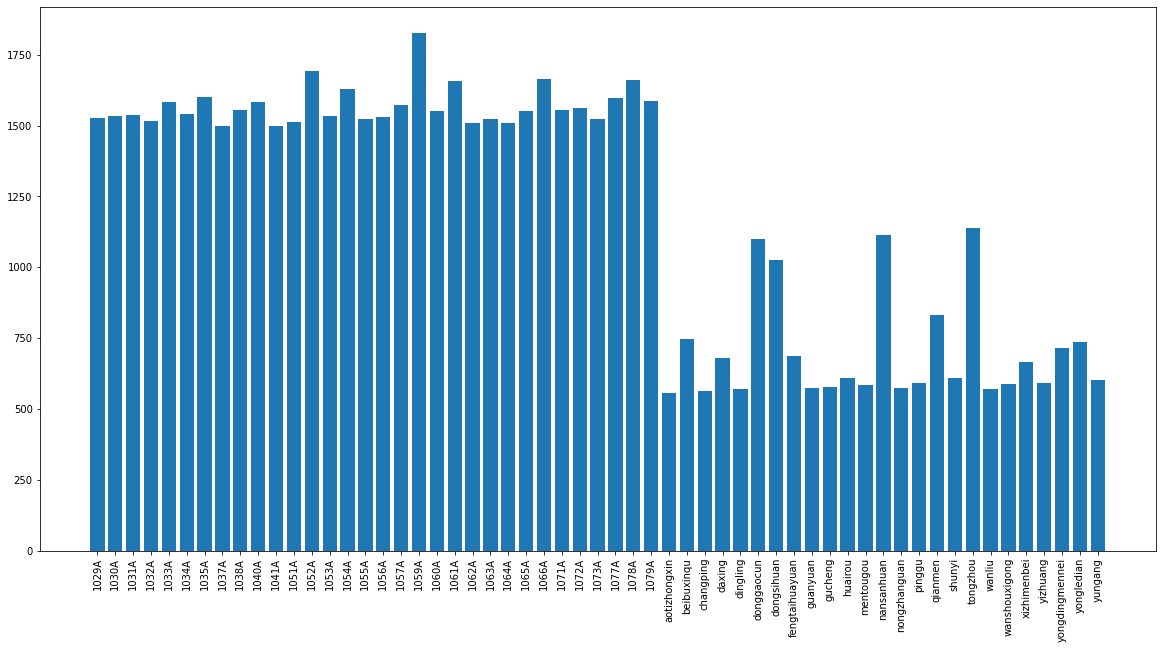

In [61]:
missing_by_device = export_df[mask].groupby('device_id').count()

plt.figure(figsize=(20,10))
plt.bar(missing_by_device.index, missing_by_device['time'])
plt.xticks(missing_by_device.index, rotation='vertical')
plt.show()

In [85]:
@interact(devices=device_widget, mapping=fixed(dic))
def exclude(devices, mapping):
    exclude_devices = list(map(lambda x: mapping[x], devices))
    x = export_df[mask][~export_df[mask]['device_id'].isin(exclude_devices)]

    missing_by_time = x.groupby(x.index).count()

    plt.figure(figsize=(20,10))
    plt.plot(missing_by_time.index, missing_by_time['device_id'])
    plt.show()
    print(exclude_devices)

interactive(children=(SelectMultiple(description='Devices', index=(0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

In [81]:
%matplotlib widget

In [84]:
missing_by_time = export_df[mask].groupby(export_df[mask].index).count()

plt.figure(figsize=(20,10))
plt.plot(missing_by_time.index, missing_by_time['pm25'])
#plt.xticks(missing_by_time.index, rotation='vertical')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [80]:
export_df[mask]

,device_id,time,2m_temperature,relative_humidity+950,total_precipitation,wind_speed,wind_direction,pm25
time,,,,,,,,
2016-03-08 02:00:00,guanyuan,2016-03-08 02:00:00,0.233333,22.0,0.0,7.28,41.0,NaN
2016-03-15 14:00:00,guanyuan,2016-03-15 14:00:00,11.733333,35.0,0.0,4.08,200.0,NaN
2016-04-02 14:00:00,guanyuan,2016-04-02 14:00:00,17.866667,14.0,0.0,15.65,290.0,NaN
2016-04-03 14:00:00,guanyuan,2016-04-03 14:00:00,18.866667,11.0,0.0,4.48,180.0,NaN
2016-04-18 08:00:00,guanyuan,2016-04-18 08:00:00,13.866667,31.0,0.0,6.72,0.0,NaN
...,...,...,...,...,...,...,...,...
2020-10-27 02:00:00,1079A,2020-10-27 02:00:00,13.944444,61.0,0.0,9.54,2.0,NaN
2020-10-28 14:00:00,1079A,2020-10-28 14:00:00,18.127778,15.0,0.0,3.36,139.0,NaN
2020-11-04 14:00:00,1079A,2020-11-04 14:00:00,21.116667,13.0,0.0,12.85,176.0,NaN


In [79]:
temp = missing_by_time.copy()
temp['time'] = temp.index
temp.to_numpy()

5810×8 object ndarray


interactive(children=(Text(value='[:100, :]', description='Slice:', placeholder='e.g. [:100, :]'), Output()), …

In [42]:
export_grouped = export_df.groupby('device_id').apply(pd.DataFrame.to_numpy)
y = list(map(lambda x: x[:,1:], export_grouped))

In [43]:
# time × city × measure (17 features, 1 col for PM25)
z = np.array(y)
z = z.swapaxes(0, 1)
z

14616×87×7 object ndarray


interactive(children=(Text(value='[:100, :, 0]', description='Slice:', placeholder='e.g. [:100, :, 0]'), Outpu…